## This script takes table weather data scrapped from online sourse and  

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import os
import csv

PATH = 'H:\\CrashWeatherData\\DATA INFO\\'
PATH2 = 'H:\\CrashWeatherData\\SCRAPPER\\'

# Only used to generate .db File

## Building Dataframe

Building Dataframe
SELECT * (*=ALL COLUMNS) FROM Table Where (CONDITIONS)
.db CONSTRUCTED ON WEATHERDATA.PY
Once .db is made you can reference it freely for other files

df = pd.read_sql_query('SELECT * FROM data_use WHERE Date1 <= 20180626 and Camera == 2795', csv_database)

In [24]:
def CreatDataBase(DIR, FILE, NewName):
    
# --- Examples --- 
#   DIR = 'H:\\CrashWeatherData'
#   FILE = '\\8month_acceleration_with_crashes.csv'
    file = '{}{}'.format(DIR, FILE)

    print('File directory: {}'.format(file))
    # ---  encoding='latin1'--- # Needed to remove non ascii
    csv_database = create_engine('sqlite:///H:\\CrashWeatherData\\DataBase\\csv_database' + NewName + '.db', encoding='latin1')
 
    #########################
    chunksize = 1000
    i = 0
    j = 0

    for df in pd.read_csv(file, chunksize=chunksize, iterator=True, encoding='latin1'):
        # No Spaces
        df = df.rename(columns = {c: c.replace(' ', '') for c in df.columns})
        df.index += j
        # NEW NAME FOR DATABASE
        df.to_sql('data_use', csv_database, if_exists = 'append')
        # n[-1] means the last item in the list n
        j = df.index[-1]+1

        print('| index: {}'.format(j))
        
    return df

# --- EG --- # 
# Newdf = CreatDataBase('H:\\CrashWeatherData\\SCRAPPER', '\\KGAATLAN330WeatherScraper.csv', 'KGAATLAN330WeatherScraper')
# --- Load to pd --- #
# csv_database = create_engine('sqlite:///H:\\CrashWeatherData\\csv_database.db', encoding='latin1')

In [25]:
# csv_database = create_engine('sqlite:///H:\\CrashWeatherData\\csv_database.db', encoding='latin1')

## Get Station List
 by calling  Newdf = CreatDataBase('H:\\CrashWeatherData\\SCRAPPER', '\\KGAATLAN330WeatherScraper.csv',                        'KGAATLAN330WeatherScraper')

In [26]:
## --- Returns list of all stations --- #
def ListStations():
    PATH = 'H:\\CrashWeatherData\\DATA INFO\\'
    PATH2 = 'H:\\CrashWeatherData\\SCRAPPER\\'
    with open(PATH + 'Station-Latitude-Longitude-EDITED.csv', 'r') as csvStations:
        csv_Stations = csv.reader(csvStations)
        next(csv_Stations) # --- Skips header --- #
        Total_Stations = []
        for StationsList in csv_Stations:
            Total_Stations.append(StationsList[0])
    return Total_Stations
        

## Generate Total .db File

In [27]:
# # --- TOTAL DB for crash data --- #
# Totaldf = CreatDataBase('H:\\CrashWeatherData', '\\8month_acceleration_with_crashes.csv', 'TOTAL')
# Total = create_engine('sqlite:///H:\\CrashWeatherData\\DataBase\\csv_databaseTOTAL.db', encoding='latin1')

## Plotting Data / Generating Map / Assigning Cameras to Nearest Stations

In [28]:
from geopandas import GeoSeries
import geopandas
import numpy as np
import pandas as pd
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
import missingno as msn
import seaborn as sns
import matplotlib.pyplot as plt

import contextily as ctx
import folium
%matplotlib inline


# --- Plot Options --- #
# StationCoordinatesCSV.info()
# msn.bar(StationCoordinatesCSV, color='darkolivegreen')
# StationCoordinatesCSV.describe()

# StationCoordinatesCSV.plot(figsize=(20,10))

In [29]:

#######################################################################################
def CreatePointMap(PATH, file):
    
    df = pd.read_csv(PATH + file)
    # --- Converts df type to GeoDataFrame --- #
    pointDF = df
    df['coordinates'] = df[['Latitude', 'Longitude']].values.tolist()
 
    df['coordinates'] = df['coordinates'].apply(Point)
    df = geopandas.GeoDataFrame(df, geometry='coordinates')
    
    return df, pointDF


#######################################################################################
def GeneratePointMap(Names , Latitudes, Longitudes, color, radius):
    
    i = 0
    for Name in Names.iterrows():
        folium.CircleMarker(
            location=[Latitudes.iloc[i,0],Longitudes.iloc[i,0]],
            tooltip = Names.iloc[i,0],
            radius= radius,
            popup=Names.iloc[i,0],
            color=color,
            fill=True,
            fill_color=color 
        ).add_to(m)
        i += 1

        
############### --- Voronoi Diagram --- ###############       
def Voronoi(point_df):
    
    import scipy
    from scipy.spatial import Voronoi, voronoi_plot_2d
    
    #### --- Add Placeholders --- ####
    filePH = "Station-Latitude-Longitude-PLACEHOLDERS.csv"
    dfPH, pointDFPH = CreatePointMap(PATH, filePH)
    dfPH.dropna(inplace=True)
    Names = dfPH.loc[:,['Station']]
    Latitudes = dfPH.loc[:,['Latitude']]
    Longitudes = dfPH.loc[:,['Longitude']]
    GeneratePointMap(Names , Latitudes, Longitudes, 'gray', radius=10)
    
    
    result = point_df.append(dfPH, sort=False)
  
    
    Point_list_stations = result[['Latitude', 'Longitude']].values.tolist()
    vor = scipy.spatial.Voronoi(Point_list_stations)
    voronoi_plot_2d(vor)
    plt.show()
    
    
    from geojson import FeatureCollection, Feature, Polygon
    #The output file, to contain the Voronoi diagram we computed:
    vorJSON = open('H:\\CrashWeatherData\\Maps\\VoronoiDiagram.geojson', 'w')
    point_voronoi_list = []
    feature_list = []
    polygons = []
    for region in range(len(vor.regions)-1):
        vertex_list = []
        for x in vor.regions[region]:
            if x == -1:
                vertex = vor.vertices[x]
                break;
            else:
                #Get the vertex out of the list, and flip the order for folium:
                vertex = vor.vertices[x]
                vertex = (vertex[1], vertex[0])
            vertex_list.append(vertex)
        
        if len(vertex_list) > 2:
            #Save the vertex list as a polygon and then add to the feature_list:

            polygon = Polygon([vertex_list])
            feature = Feature(geometry=polygon, properties={})
            feature_list.append(feature)
            polygons.append(polygon)
            
    g = geopandas.GeoSeries(polygons)
    i = 0
    polys = {}
    for items in g:
        polys[str(i)] = g[i]
        i += 1
    
    #Write the features to the new file:
    feature_collection = FeatureCollection(feature_list)
    # --- Why must you print to file--- #
    print (feature_collection, file=vorJSON)
    vorJSON.close()

    country_geo = 'H:\\CrashWeatherData\\Maps\\VoronoiDiagram.geojson'

    m.choropleth(geo_data=country_geo , fill_color = "darkblue", 
                fill_opacity=0.05, line_opacity=1, line_color = 'darkgreen', line_weight=7)     
    
    return feature_list, polys, result



# --- Sperate --- #
def Seperate(polys, result, point_df_C, name):
    
    result['coordinates2'] = result[['Longitude', 'Latitude']].values.tolist()
    result['coordinates2'] = result[['Longitude', 'Latitude']].values.tolist()
    result['coordinates2'] = result['coordinates2'].apply(Point)
    
    Point_S_LISTER = result['coordinates2'].to_list()
    Station_S_LISTER = result['Station'].to_list()

    pnts = geopandas.GeoDataFrame(geometry=Point_S_LISTER, index=Station_S_LISTER)
    pnts = pnts.assign(**{key: pnts.within(geom) for key, geom in polys.items()})   
    
    columns = pnts.columns.tolist()
    columns.remove('geometry')
    
    # --- Give dictionary correct station key's --- #
    for col in columns:
        true = pnts.index[pnts[str(col)] == True].tolist()
        text = str(true)
        t = text.translate(str.maketrans({'[': '', ']': '', ',': ''}))
        polys[t] = polys.pop(str(col))
           
    point_df_C['coordinates2'] = point_df_C[['Longitude', 'Latitude']].values.tolist()
    point_df_C['coordinates2'] = point_df_C[['Longitude', 'Latitude']].values.tolist()
    point_df_C['coordinates2'] = point_df_C['coordinates2'].apply(Point)

    Point_C_LISTER = point_df_C['coordinates2'].to_list()
    Station_C_LISTER = point_df_C[str(name)].to_list()
    
    pnts2 = geopandas.GeoDataFrame(geometry=Point_C_LISTER, index=Station_C_LISTER)
    pnts2 = pnts2.assign(**{key: pnts2.within(geom) for key, geom in polys.items()})
    
    # --- Get Objects in ploygon that has been assigned to a station --- #
    columns = pnts2.columns.tolist()
    columns.remove('geometry')
    columns.remove('')

    camera_PRE_station = {}
    for col in columns:

        true = pnts2.index[pnts2[str(col)] == True].tolist()
        text = str(col)
        col_text = text.translate(str.maketrans({'[': '', ']': '', ',': '', "'":''}))
        if len(true) != 0:
            camera_PRE_station[col_text] = true
    
    return camera_PRE_station

In [30]:
# --- Generate Map --- #
center = [33.748997, -84.387985]
m = folium.Map(center, zoom_start=10)
m.save('index.html')

m = folium.Map(
    location=[33.748997, -84.387985],
    tiles='Stamen Toner',
    zoom_start=10
)

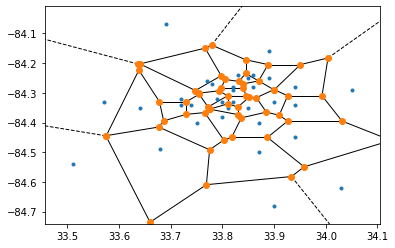

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [31]:
# --- PLOT STATIONS --- #
import geoplot

file = 'Station-Latitude-Longitude-EDITED.csv'
StationCoordinatesDF, point_df_S = CreatePointMap(PATH, file)

# --- VORONOI DIAGRAM --- #
vertex_list , polys, result = Voronoi(point_df_S)

Names = StationCoordinatesDF.loc[:,['Station']]
Latitudes = StationCoordinatesDF.loc[:,['Latitude']]
Longitudes = StationCoordinatesDF.loc[:,['Longitude']]
GeneratePointMap(Names , Latitudes, Longitudes, 'darkgreen', 15)

In [32]:
# --- PLOT CAMERAS --- #
file2 = 'Camera-Latitude-Longitude.csv'
CamLocadf , point_df_C = CreatePointMap(PATH, file2)

Names = CamLocadf.loc[:,['camera']]
Latitudes = CamLocadf.loc[:,['Latitude']]
Longitudes = CamLocadf.loc[:,['Longitude']]
GeneratePointMap(Names , Latitudes, Longitudes, 'maroon', radius=5)

# --- This function returns a dict of call cameras in a particular station --- #
camera_PRE_station = Seperate(polys, result, point_df_C, 'camera')

In [33]:
# --- Print map if needed --- #
m


In [34]:
m.save('index.html')

## Create a local database for each station

In [13]:
# --- Create Database for each station (not needed because csv is fast enough at this size) --- #
station_keys = [*camera_PRE_station]
# for StationName in station_keys:
#     Newdf = CreatDataBase('H:\\CrashWeatherData\\SCRAPPER', '\\' + StationName + 'WeatherScraper.csv', StationName + 'WeatherScraper')
#     break

In [14]:
# --- GetDate --- #
from datetime import datetime
from datetime import timedelta

def DeltaDays(day):
    
    date_format = "%Y%m%d"
    d0 = datetime.strptime(str(day), date_format)
    d1 = datetime.strptime('20171001', date_format)
    delta = d0 - d1
    delta = (delta.days)
    NewTime = (d1 + timedelta(days=(delta)) ).strftime('%Y%m%d')
    
    return delta

# --- Given min get new date --- #
def min2date(mins):
    
    
    date_format = "%Y%m%d"
    day = int(int(mins)/1440)
    mins = int(mins) - (day*1440)
    hour = int((mins/1440)*24)
    delta = day
    date_format = "%Y%m%d"
    d1 = datetime.strptime('20171001', date_format)
    NewTime = (d1 + timedelta(days=(delta)) ).strftime('%Y%m%d')
    
    return NewTime, day, hour, mins

def date2list(start, end):
    date_format = "%Y%m%d"
    d0 = datetime.strptime(start, date_format).date()
    d1 = datetime.strptime(end, date_format).date()
    delta = d1 - d0
    delta.days
    datelist = []

    datelist.append(d0.strftime('%Y%m%d'))
    count = 0
    delta = d1 - d0
    delta = (delta.days)
    while delta > 0:
        delta -= 1 
        count += 1
        NewTime = (d0 + timedelta(days=(count)) ).strftime('%Y%m%d')
        datelist.append(str(NewTime))
        
        
    return datelist
    
    


# --- Time converter --- #  
def TimeConverter(item):
        Time = (int(int(item)/100))*60 + (item % 100)
        return Time

# --- Table values were miss matched and at diffent frequencies this function adds padding --- # 
def Sort_aline(df, DateColName, TimeColName, Time_List, name):
    
    list_of_columns = df.columns.values
    df_New = pd.DataFrame(columns=list_of_columns)
    j = 0
    try:
        for NA, row in df.iterrows():

                print(Time_List[j])
                
                dateW = df.loc[NA,[str(DateColName)]]
                timeW = df.loc[NA,[str(TimeColName)]]
                timeW = timeW[0]
                deltaW = DeltaDays(str(dateW[0]))
                days2minsW = deltaW*24*60
                time_totalW = (int(timeW/100))*60 + (timeW % 100) + days2minsW

                body = np.append(row.values, [Time_List[j]])
                header = np.append(df.columns.values, ['Time in Minutes'])


                if (int(Time_List[j]) - 3) <= time_totalW <= (int(Time_List[j]) + 3) and (int(Time_List[j]) <= 4080):

                    body = np.append(row.values, [Time_List[j]])
                    header = np.append(df.columns.values, ['Time in Minutes'])
                    df_line = pd.DataFrame([body], columns=list(header))
                    df_New = df_New.append(df_line, sort = False)
                    j += 1

                elif (int(Time_List[j]) + 3) < time_totalW and (int(Time_List[j]) <= 4080):

                    row_count = 0
                    change = (time_totalW - int(Time_List[j]))/5
                    change = int(change)
                    gap_count = 0 

                    while row_count <= change:
                        gap_count += 1
                        if gap_count > 18:
                            with open(PATH + '\\Stations with Cameras\\Errors\\' + 'ErrorReport' + name + '.csv', 'a', newline='') as csvError:
                                csvErrorReport = csv.writer(csvError)
                                csvErrorReport.writerow(['More than an hour and a half of missing time at: ' + str(time_totalW)])
                                gap_count = 0
                                
                        body = np.append(row.values, [Time_List[j]])
                        header = np.append(df.columns.values, ['Time in Minutes'])

                        df_line = pd.DataFrame([body], columns=list(header))
                        df_New = df_New.append(df_line, sort = False)
                        j += 1
                        row_count += 1

                # - limit date - #
                elif int(Time_List[j]) > 4080:
                    return df_New, j
                    
                    
                else: 
                    gap_count += 1
                    if gap_count > 18:
                        with open(PATH + '\\Stations with Cameras\\Errors\\' + 'ErrorReport' + name + '.csv', 'a', newline='') as csvError:
                            csvErrorReport = csv.writer(csvError)
                            csvErrorReport.writerow(['More than an hour and a half of missing time at: ' + str(time_totalW)])
                            gap_count = 0

    except IndexError:
        return df_New, j   

    return df_New, j

def myround(x, base=5):
    return base * round(x/base)

In [15]:
# --- Inputs: the weather data, camera data, dictionary of cameras divided to stations --- #
# --- Output: a concatenated list with each station and its cameras --- #

day = '20180621'
delta = DeltaDays(str(day))
n = (262*24*60)/5
i = 1
Time_List = []



while i < n:
    item_num = 5*int(i)
    Time_List.append(str(item_num))
    i += 1                 

df_5min_intdict = {'Time in Minutes' : Time_List}                     
df_5min_int = pd.DataFrame({'Time in Minutes' : Time_List})


finallistUSED = ['KGATUCKE14', 'KGAATLAN326', 'KGATUCKE4', 'KGAAVOND8', 'KGAATLAN276', 'KGASIBLE2', 'KGAATLAN46', 'KGAATLAN195', 'KGADUNWO9', 'KGAATLAN85', 'KGAATLAN25', 'KGADECAT47', 'KGAAVOND3']
csv_databaseTOTAL = create_engine('sqlite:///H:\\CrashWeatherData\\DataBase\\csv_databaseTOTAL.db', encoding='latin1')

# --- High to low --- #
station_keys. reverse()
for StationName in finallistUSED:
#for StationName in finallistUSED:
# --- USE this after you get all of the data --- # for StationName in station_keys:
    print(StationName)
    name =  'Station-'+ str(StationName)
    dfWEATHER = pd.read_csv('H:\\CrashWeatherData\\SCRAPPER\\' + StationName + 'WeatherScraper.csv', encoding='latin1')
    # Creating an empty Dataframe with column names only
    sorted_S_df ,j = Sort_aline(dfWEATHER, 'Date2', 'Time2', Time_List, name)

    for camera in camera_PRE_station[str(StationName)]:

        print(camera)
        dfCRASH = pd.read_sql_query('SELECT Date1, Time1, ComboID, speed, acc1, SOURCE_ID, camera, LatDecimal, LongDecima, CURVA RAD_CURV, intersection, Anti1Clock0 FROM data_use WHERE Date1 < 20180621 and AccidentNo == 0 and Camera == ' + str(camera), csv_databaseTOTAL)
        print('Built new camera dataframe')
        name =  'Camera-'+ str(camera)
        sorted_C_df ,j = Sort_aline(dfCRASH, 'Date1', 'Time1', Time_List, name)
        print('DONE')
        mergedf = pd.merge(sorted_S_df, sorted_C_df, on='Time in Minutes', how='outer')
        del sorted_C_df
        sorted_S_df = mergedf
    mergedf.to_csv(PATH + '\\Stations with Cameras\\' + StationName + 'DataForEachStation' '.csv', index=False)  
print('Done')


## Time Calulator Tool

In [16]:
# --- used commands for building --- #
pd.options.display.max_rows = None
pd.options.display.max_columns = None

dateW = 20171021
timeW = 2000

deltaW = DeltaDays(str(dateW))
days2minsW = deltaW*24*60
time_totalW = (int(timeW/100))*60 + (timeW % 100) + days2minsW
time_totalW

30000

## SPLITTER

In [17]:
keypath = 'H:\\CrashWeatherData\\DATA INFO\\Stations with Cameras\\'

for station in station_keys:
    print(station)
    file_name = str(PATH) + '\\Stations with Cameras\\' + str(station) + 'DataForEachStation.csv'
    file_obj = open(file_name, encoding="utf-8")
    w = range(13)
    weather_r = [*w] 
    r = range(12)
    r = [*r]
    crash_r = list(map(lambda x: x + 13, r))
    master = pd.read_csv(file_obj, low_memory=False)
    for cam in camera_PRE_station[str(station)]:
        cols = weather_r + crash_r
        m = master.iloc[:, cols]
        m.to_csv(PATH + '\\Stations with Cameras\\FinalCSV\\' + str(station) + ' ' + str(cam) + '.csv', index=False)
        crash_r = list(map(lambda x: x + 12, crash_r))
         
        
       

## PLOTTING CRASHES / SAVING FILE
# --------------------------------------------------------------------------------------------------------------

In [18]:
csv_databaseTOTAL = create_engine('sqlite:///H:\\CrashWeatherData\\DataBase\\csv_databaseTOTAL.db', encoding='latin1')
# dfCRASH = pd.read_sql_query('SELECT Date1, Time1, ComboID, speed, acc1, SOURCE_ID, camera, LatDecimal, LongDecima, CURVA RAD_CURV, intersection, Anti1Clock0 FROM data_use WHERE Date1 < 20180621 and AccidentNo == 1 and Camera == ' + str(camera), csv_databaseTOTAL)
CRASH = pd.read_sql_query('SELECT * FROM data_use WHERE Date1 < 20180621 and AccidentNo != 0', csv_databaseTOTAL)
# long_late = CRASH[['camera','LatDecimal','LongDecima','AccidentNo']]
# long_late.columns = ['camera','Latitude','Longitude','AccidentNo']
# long_late.to_csv(PATH + '\\CRASH-Latitude-Longitude.csv', index=False)

In [19]:
file = 'CRASH-Latitude-Longitude.csv'
df, pointDF = CreatePointMap(PATH, file)
Names = df.loc[:,['camera']]
Latitudes = df.loc[:,['Latitude']]
Longitudes = df.loc[:,['Longitude']]
GeneratePointMap(Names , Latitudes, Longitudes, 'red', radius=1)
# CRASH_PRE_station = Seperate(polys, result, pointDF, 'AccidentNo')

In [20]:
# m.save(PATH + 'map.html')

## Error Counter
# --------------------------------------------------------------------------------------------------------------

In [21]:
import os
#path to errors
path = 'H:\\CrashWeatherData\\DATA INFO\\Stations with Cameras\\Errors\\'

date_format = "%Y%m%d"

frequency_dict_C = {}
frequency_dict_S = {}
for file in os.listdir(path):
    with open(path + file, 'r') as fileinput:
        file = file.replace('ErrorReport', '')
        name = file.replace('.csv', '').split('-')
        error = csv.reader(fileinput)
        time_list = []
        unique_list = [] 
        for row in fileinput:
            row_time = row.replace("More than an hour and a half of missing time at: ","")
            row_time = row_time.replace("\n","")
            time_list.append(row_time)
            if row_time not in unique_list:
                unique_list.append(row_time)
        
        totallist = []
        removelist = []
        for mins in unique_list:
            start_date, days, hours = min2date(mins)
            conSec = time_list.count(str(mins))
            deltaH = int((conSec)*1.5)
            deltaHT = deltaH + hours
            deltaD = int(deltaHT/24)
            d1 = datetime.strptime(str(start_date), date_format)
            Start_date = (d1 - timedelta(days=(deltaD)) ).strftime('%Y%m%d')
            mins = myround(int(mins))
            
            if conSec > 2:
                rowsRM = 18*conSec
                start = (int(mins) - int(rowsRM*5))
                while start <= int(mins):
                    removelist.append(int(start))
                    start = (int(start) + 5)

        if name[0] == 'Station':
            frequency_dict_S[str(name[1])] = removelist   
        frequency_dict_C[str(name[1])] = removelist

# cleaning data of instances where weather does not line up with the other sources 
remove_csv = {}
for station in [*camera_PRE_station]:
    print(station)        
    missing = frequency_dict_S[str(station)]
    unique_list = [] 
    for item in missing:
        if item not in unique_list:
            unique_list.append(int(item))
    df = pd.read_csv('H:\\CrashWeatherData\\DATA INFO\\Stations with Cameras\\TEST\\' + str(station) + '.csv', low_memory=False, encoding='latin1') 
    df.columns = ['Date2', 'Time2', 'Temperature', 'Dew Point', 'Humidity', 'Wind',
       'Speed', 'Gust', 'Pressure', 'Precip. Rate.', 'Precip. Accum.', 'None',
       'Time']
    df_edited = df[~df.Time.isin(unique_list)]
    df_edited.to_csv(PATH + '\\Stations with Cameras\\TEST2\\' + str(station) + '.csv', index=False)
    print('df made' + str(station) + '-' +  '.csv')

## Only used for exploring data/ One-Hot
# --------------------------------------------------------------------------------------------------------------

In [ ]:
def NaNconverter(x):
    try:
        convert = {'None': 0, None: 0, ' ': 0, 'nan': 0, '00': 0}
        x = convert[str(x)]
    except KeyError:
        return x
    return x    

def lightconvert(x):
    convert = {'Daylight': 1, 'DarkLighted': 2, 'Dusk': 3, 'DarkNot Lighted': 4, ' ' : 0, 'Dawn': 5, '0': 0}
    x = convert[str(x)]
    return x

def surfaceconvert(x):
    convert = {'Dry': 'Dry', 'Wet': 'Wet', ' ': 0, 'Slush': 'Snow', 'Water (standing or moving)': 'Water (standing or moving)', 'Snow': 'Snow', 'Ice/Frost': 'Snow', '0': 0, 'Other': 0}
    x = convert[str(x)]
    return x

def speedconvert(x):
    x = str(x)
    x = x.replace('Â\xa0mph', '')
    try:
        x = x.replace('Ã\x82', '')
    except:
        return x
    return x

def dirconvert(x):
    convert = { None: 0, 'None': 0, ' ': 0, 'ENE': 16, 'South': 1, 'East': 2, 'SW': 3, 'Southwest': 3,
               'West': 4, 'North': 5, 'ESE': 6, 
               'NW': 7, 'Northwest': 7, 'NNW': 8, '0': 0,
               'NE': 9, 'Northeast': 9, 'WSW': 10, 'SSW': 11, 'NNE': 12, 'SE': 13, 'Southeast': 13, 'WNW': 14, 'SSE': 15
              }
    x = convert[str(x)]
    return x

def safe(x):
    try:
        convert = { '0': 0, None: 0, 'None': 0, ' ': 0, 'Unknown': 0, 'Bicycle Helmet': 'Helmet', 'Motorcycle Helmet': 'Helmet', 'Non-Motorist Lighting': 0}
        x = convert[str(x)]
    except KeyError:
        return x
    return x

def Mnvr(x):
    try:
        convert = { '0': 0, None: 0, 'None': 0, ' ': 0, 'Unknown': 0, 'Other': 0, 'PIT': 0 }
        x = convert[str(x)]
    except KeyError:
        return x
    return x

def CarSize(x):

    convert = { '0': 0, None: 0, 'None': 0, ' ': 0, 'Unknown': 0, 'Other': 0, 'Pickup Truck': 'M', 'Passenger Car': 'M',
              'Sports Utility Vehicle (SUV)': 'M', 'Van': 'M', 'Single Unit Truck': 'L', 'Farm or Construction Equip.': 'XL',
              'Vehicle With Trailer': 'XL', 'Motorcycle': 'S', 'Truck Tractor (Bobtail)': 'XL', 'Tractor w/Twin Trailers': 'XL',
              'Panel Truck': 'L', 'Ambulance': 'L', 'Bus': 'L', 'Truck Towing House Trailer': 'XL', 'All Terrain Vehicle': 'S',
              'Motorized Recreational Vehicle': 'S', 'Tractor/Trailer': 'XL', 'Logging Tractor/Trailer': 'XL', 'Logging Truck': 'XL'}
    x = convert[str(x)]

def Construction(x):

    convert = { '0': 0, 0: 0, 'Construction': 'Construction', 'Maintenance': 'Construction', 'Unknown Type': 0}
    x = convert[str(x)]

    return x
    
    return x

def dirconvert(x):
    convert = { None: 0, 'None': 0, ' ': 0, 'ENE': 16, 'South': 1, 'East': 2, 'SW': 3, 'Southwest': 3,
               'West': 4, 'North': 5, 'ESE': 6, 
               'NW': 7, 'Northwest': 7, 'NNW': 8, '0': 0,
               'NE': 9, 'Northeast': 9, 'WSW': 10, 'SSW': 11, 'NNE': 12, 'SE': 13, 'Southeast': 13, 'WNW': 14, 'SSE': 15
              }
    x = convert[str(x)]
    return x


#-----------------------------------------------------------------------------
def OneHot(NewName, oldName, df):
    uniqueL = df[str(oldName)].unique()
    for item in uniqueL:
        if item == 0:
            pass
        elif item == 'Other':
            pass
        else:
            df[str(NewName) + '_' + str(item)] =  np.where(df[str(oldName)] == str(item), 1, 0)
    df = df.drop([str(oldName)], axis = 1)
    return df

# Combine Crash and weather data cols = 
#### ['Temperature', 'Dew Point', 'Humidity', 'Wind', 'Speed', 'Gust', 'Pressure', 'Precip. Rate.', 'Precip. Accum.', 'Time1', 'speed', 'acc1',
####       'CURVA', 'RAD_CURV', 'intersection', 'Anti1Clock0', 'camera', 'Crash', 'W_Sation'] 
# --------------------------------------------------------------------------------------------------------------

In [47]:
x = 0
i = 0
# --- Create CSV files of crashes with weather --- #
for station in [*camera_PRE_station]:
    
    # --- Crash --- #
    print(station)
    cam_list = camera_PRE_station[str(station)]
    crash_df_station = CRASH[CRASH.camera.isin(cam_list)]
    # Covert datatime to time in mins from start date
    time = crash_df_station[['Date1', 'Time1']]
    date_list = time.Date1.tolist()
    time_list = time.Time1.tolist()
    d1 = time.Date1.apply(DeltaDays, date_list)
    d1 = d1.apply(lambda x: (x * 24 * 60))
    t1 = time.Time1.apply(TimeConverter, time_list)
    t1 = t1.apply(lambda x: 5 * round(x/5))
    df = pd.concat([t1, d1], axis=1)
    df['Time'] = df['Time1'] + df['Date1']
    df = pd.concat([crash_df_station, df['Time']], axis=1)
    
    file_obj = open(PATH + 'Stations with Cameras\\StationsWoutErrors\\' + str(station) + '.csv', encoding="utf-8")
    weather = pd.read_csv(file_obj, low_memory=False)

    df_combine = pd.concat([weather, df], axis=1) #concat weather with crashdata
    mergedf = pd.merge(weather, df, on='Time', how='outer')
    mergedf = mergedf[mergedf['AccidentNo'].notna()]
    mergedf = mergedf[mergedf['Time'] < 362880] #limit time
    
    # --- Drop crashes occur without temp data --- #
    mergedf = mergedf.dropna(subset=['Temperature'])


    Cols_n_weather = ['Date2', 'Time2', 'Temperature', 'Dew Point', 'Humidity', 'Wind',
       'Speed', 'Gust', 'Pressure', 'Precip. Rate.', 'Precip. Accum.', 'None',
       'Time','Date1', 'Time1', 'ComboID', 'speed', 'acc1', 'SOURCE_ID', 
       'LatDecimal', 'LongDecima', 'CURVA', 'intersection', 'Anti1Clock0', 'camera', 'index']
    mergedf = mergedf[Cols_n_weather]
    mergedf = mergedf.drop(['Time2', 'None', 'ComboID', 'SOURCE_ID'],  axis=1)
    mergedf['Crash'] = 1

    # --- Non-Crash --- #
    for camera in camera_PRE_station[str(station)]:
        file_obj = open(PATH + 'Stations with Cameras\\FinalCSV_DROPPED\\' + str(station) + ' ' + str(camera) + '.csv'
                        , encoding="utf-8")
        pd_noncrash = pd.read_csv(file_obj, low_memory=False)
        pd_noncrash['camera'] = str(camera)
        
        # --- FIX CURVA ERROR --- #
        pd_noncrash = pd_noncrash.drop([pd_noncrash.columns[19]],  axis = "columns" ) # --- FIX ERROR --- #
        pd_noncrash['index'] = None
        pd_noncrash.columns = Cols_n_weather
        pd_noncrash = pd_noncrash.drop(['Time2', 'None', 'ComboID', 'SOURCE_ID'],  axis=1)
        
        
        pd_noncrash['Crash'] = 0
        mergedf = pd.concat([mergedf, pd_noncrash], axis=0, sort=False)
        

        print(mergedf.shape)
        
    mergedf['Speed'] = mergedf['Speed'].map(speedconvert)
    mergedf = mergedf.applymap(NaNconverter)
    mergedf['Wind'] = mergedf['Wind'].map(dirconvert)
    Station_Num = {
         'KGAATLAN378': 0, 'KGAFORES2': 1, 'KGASMYRN21': 2,
         'KGATUCKE14': 3, 'KGAATLAN326': 4, 'KGATUCKE4': 5,
         'KGAAVOND8': 6, 'KGAATLAN276': 7, 'KGASIBLE2': 8,
         'KGAATLAN46': 9, 'KGAATLAN195': 10, 'KGADUNWO9': 11,
         'KGAATLAN85': 12, 'KGAATLAN25': 13, 'KGADECAT47': 14, 'KGAAVOND3': 15
        }
    mergedf['W_Sation'] = Station_Num[str(station)]
    mergedf = mergedf[mergedf['Date1'] != 0]
    mergedf = mergedf[mergedf['Date2'] != 0]
    
    if x == 1: 
        mergedf = pd.concat([mergedf, mergedf2], axis=0)
        
    mergedf2 = mergedf
    print(mergedf2.shape)
    x = 1

# --- Save File --- #
mergedf2.to_csv(PATH + 'Stations with Cameras\\CrashWweather\\Fixed_indexed_Total_DataFrame.csv', index=False)      
#-------------------------------------------------------------------------------------------------------------------

KGAATLAN378
(66854, 23)
(130772, 23)
(195080, 23)
(259481, 23)
(322733, 23)
(386088, 23)
(441314, 23)
(482126, 23)
(546440, 23)
(611205, 23)
(675227, 23)
(741105, 23)
(807056, 23)
(872466, 23)
(937982, 23)
(999536, 23)
(1060333, 23)
(1126592, 23)
(1192851, 23)
(1253128, 23)
(1319497, 23)
(1385866, 23)
(1449564, 23)
(1512270, 23)
(1574658, 23)
(1641027, 23)
(1704871, 23)
(1767166, 23)
(1832381, 23)
(1897884, 23)
(1962989, 23)
(2026706, 23)
(2089736, 23)
(2152534, 23)
(2216504, 23)
(2280508, 23)
(2344442, 23)
(2405490, 23)
(2462800, 23)
(2526947, 23)
(2591297, 23)
(2656512, 23)
(2718807, 23)
(2785176, 23)
(2851545, 23)
(2917914, 23)
(2977218, 23)
(3040270, 23)
(3104366, 23)
(3170735, 23)
(3236036, 23)
(3299332, 23)
(3362996, 23)
(3423884, 23)
(3485102, 23)
(3549829, 23)
(3608599, 23)
(3674027, 23)
(3705925, 23)
(3769319, 23)
(3832588, 23)
(3896902, 23)
(3960022, 23)
(4026102, 23)
(4089457, 23)
(4155537, 23)
(4219938, 23)
(4284301, 23)
(4345336, 23)
(4353469, 23)
(4416901, 23)
(4481898, 2